In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
from tensorflow import keras
import pandas as pd
import seaborn as sns
from training_utils import *

In [29]:
dataset = load_datasets()
figure_dir = "plots"
with gzip.open("para.pkl.gz","r+b") as f:
        dic = pickle.load(f)

        para = dic["para1"]
        para2 = dic["para2"]
        para3 = dic["para3"]
        para4 = dic["para4"]
        para5 = dic["para5"]
        model_dict = para["models"]
        hist_dict = para["history"]
        X_norms = para["X_norms"]
        Y_norms = para["Y_norms"]

        model2 = para2["model"]
        X_norms2 = para2["X_norms"]
        Y_norms2 = para2["Y_norms"]

        model3 = para3["model"]
        X_norms3 = para3["X_norms"]
        Y_norms3 = para3["Y_norms"]

        model4 = para4["model"]
        X_norms4 = para4["X_norms"]
        Y_norms4 = para4["Y_norms"]

        model5 = para5["model"]
        X_norms5 = para5["X_norms"]
        Y_norms5 = para5["Y_norms"]

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-06 17:06:52         1334
metadata.json                                  2023-03-06 17:06:52           64
variables.h5                                   2023-03-06 17:06:52        12464
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
...optimizer
......vars
.........0
...vars
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-06 17:06:52         1336
metadata.json                                  2023-03-06 17:06:52           64
variables.h5                                   2023-03-06 17:06:52        12464
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...laye

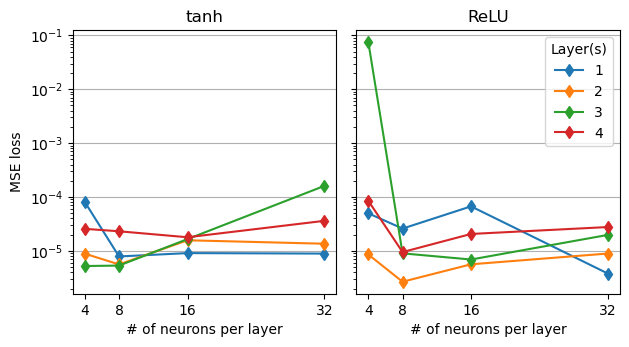

In [30]:
x_dict = {4:0, 8:1, 16:2, 32:3}
x = [4,8,16,32]
y_tanh = np.zeros((4,4))
y_relu = np.zeros((4,4))

for k,v in hist_dict.items():
    paras = k.split("_")
    arr = y_tanh
    if paras[0] == "relu":
        arr = y_relu
    l = int(paras[1])
    n = int(paras[2])
    arr[l-1, x_dict[n]] = np.min(v.history["loss"])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True,subplot_kw=dict(box_aspect=1, xlabel="# of neurons per layer", xticks=x, yscale="log"))

ax1.set_title("tanh")
for i in range(len(y_tanh)):
    ax1.plot(x, y_tanh[i], marker='d', label=f"{i+1}")

ax1.grid(axis='y')
ax1.set_ylabel("MSE loss")
ax1.set_axisbelow(True)


ax2.set_title("ReLU")
for i in range(len(y_relu)):
    plt.plot(x, y_relu[i], marker='d', label=f"{i+1}")
ax2.legend(title="Layer(s)")
ax2.grid(axis='y')
ax2.set_axisbelow(True)


fig.tight_layout()
fig.savefig(f"{figure_dir}/para1.svg",bbox_inches="tight")

plt.show()

In [31]:
model = model_dict["relu_2_8"]
value_dict = {"4-45":"tab:blue", "4-HV":"tab:red", "1-HV":"tab:green", "1-22p5":"tab:orange"}

df1 = evaluate_model(model, dataset, X_norms, Y_norms)

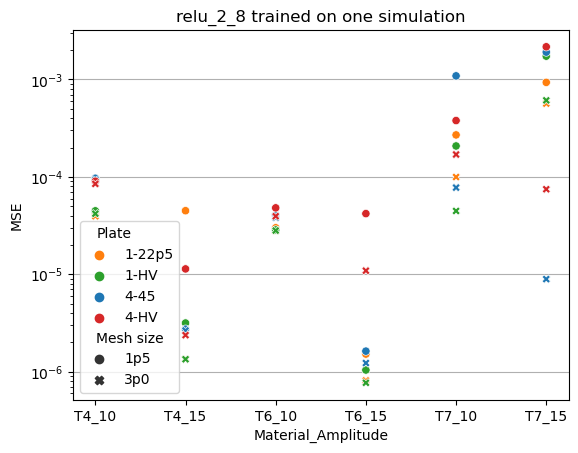

In [32]:

ax1 = sns.scatterplot(data=df1, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")
ax1.set_axisbelow(True)
ax1.grid(axis='y')
ax1.semilogy()
ax1.set_title("relu_2_8 trained on one simulation")
plt.savefig(f"{figure_dir}/all1.svg",bbox_inches="tight")
plt.show()

1/1 [==============================] - 0s 34ms/step


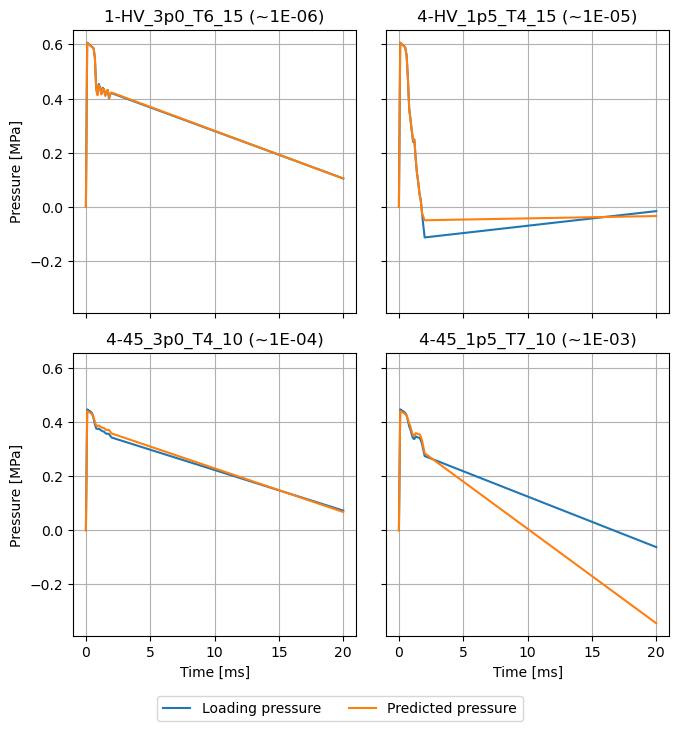

In [33]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(7,7),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1))
axs = [ax1,ax2,ax3,ax4]
names = ["1-HV_3p0_T6_15","4-HV_1p5_T4_15","4-45_3p0_T4_10","4-45_1p5_T7_10"]
df = df1
for name,ax,e in zip(names,axs,range(4)):
    db = dataset[name]
    PLAG = db["PLAG"]
    P = db["P"]
    N = db["N"]
    labels = db["labels"]
    lagp = np.ones_like(P)
    for i in range(len(lagp)):
        lagp[i] *= PLAG[i,1]

    lagp /= X_norms[0]
    N /= X_norms[1]
    P /= Y_norms[0]

    nsteps = P.shape[0]
    nels = P.shape[1]
    errors = np.zeros_like(labels)
    X = np.transpose([lagp , N])
    Y = np.transpose([P])

    Y_shape = Y.shape
    prediction = model.predict(X.reshape((Y_shape[0]*Y_shape[1],2)), batch_size=Y_shape[0]*Y_shape[1]).reshape(Y_shape)
    error = Y - prediction

    errors = np.zeros(nels)
    for i in range(nels):
        errors[i] = np.dot(error[i,:,0], error[i,:,0])/nels
    eid = errors.argmax()

    ax.set_title(f"{name} " + f"(~1E-0{6-e})")
    ax.plot(PLAG[:,0]*1000, P[:,eid]*Y_norms[0], label="Loading pressure")
    ax.plot(PLAG[:,0]*1000, prediction[eid,:,0]*Y_norms[0], label="Predicted pressure")
    #plt.plot(PLAG[:,0],N[:,eid], label="N")
    #ax.legend()
    ax.grid(axis="both")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [MPa]")
    ax.label_outer()
fig.legend(labels=["Loading pressure", "Predicted pressure"], loc='center', bbox_to_anchor=(0.5, -0.02), ncol=2)

fig.tight_layout()  
fig.savefig(f"{figure_dir}/tests1.svg",bbox_inches="tight")
plt.show()

In [34]:
df2 = evaluate_model(model2, dataset, X_norms2, Y_norms2)

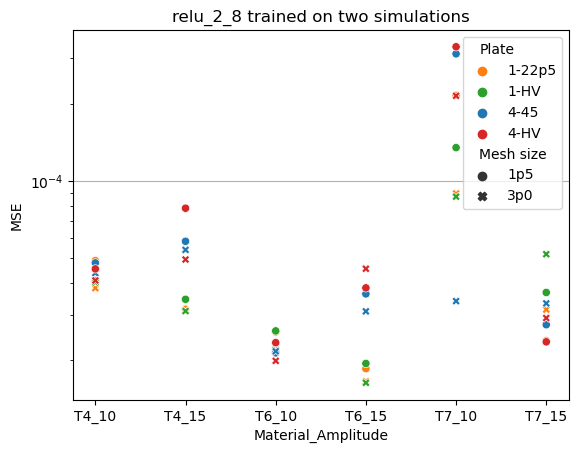

In [35]:
df = df2
ax2 = sns.scatterplot(data=df, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")
ax = ax2

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on two simulations")
plt.savefig(f"{figure_dir}/all2.svg",bbox_inches="tight")
plt.show()

In [36]:
df3 = evaluate_model(model3, dataset, X_norms3, Y_norms3)

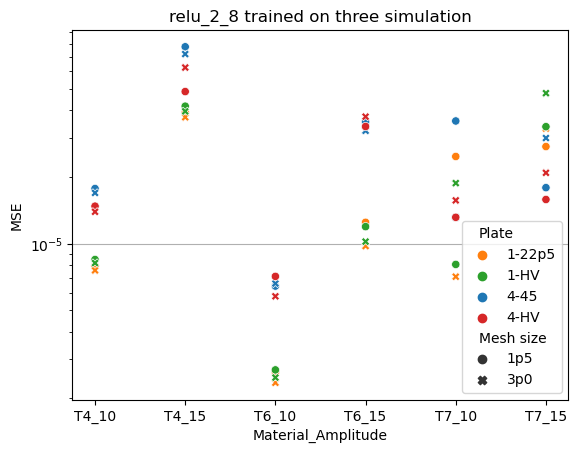

In [37]:
df = df3
ax3 = sns.scatterplot(data=df, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")
ax = ax3

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on three simulation")
plt.savefig(f"{figure_dir}/all3.svg",bbox_inches="tight")
plt.show()

1/1 [==============================] - 0s 31ms/step


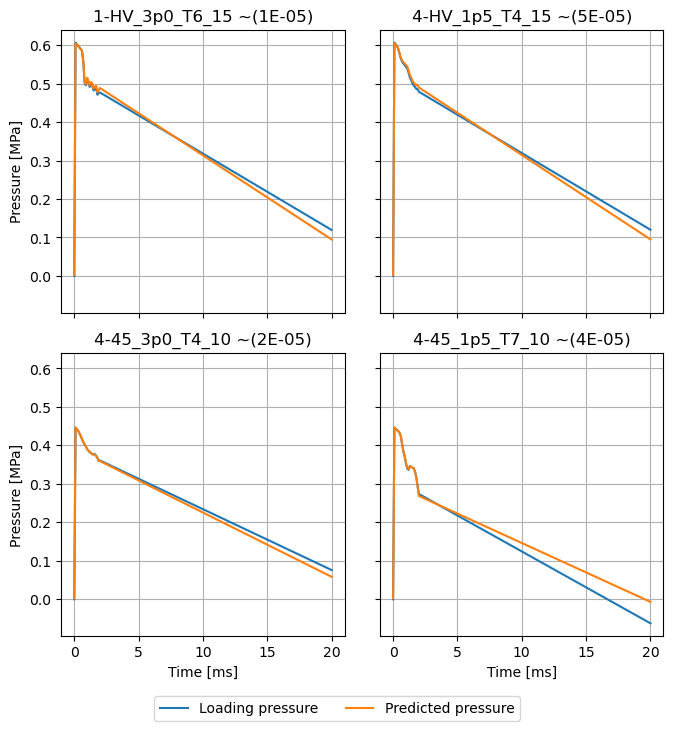

In [38]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(7,7),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1))
axs = [ax1,ax2,ax3,ax4]
names = ["1-HV_3p0_T6_15","4-HV_1p5_T4_15","4-45_3p0_T4_10","4-45_1p5_T7_10"]
df = df3
for name,ax,e in zip(names,axs,range(4)):
    db = dataset[name]
    PLAG = db["PLAG"]
    P = db["P"]
    N = db["N"]
    labels = db["labels"]
    lagp = np.ones_like(P)
    for i in range(len(lagp)):
        lagp[i] *= PLAG[i,1]

    lagp /= X_norms3[0]
    N /= X_norms3[1]
    P /= Y_norms3[0]

    nsteps = P.shape[0]
    nels = P.shape[1]
    errors = np.zeros_like(labels)
    X = np.transpose([lagp , N])
    Y = np.transpose([P])

    Y_shape = Y.shape
    prediction = model3.predict(X.reshape((Y_shape[0]*Y_shape[1],2)), batch_size=Y_shape[0]*Y_shape[1]).reshape(Y_shape)
    error = Y - prediction

    errors = np.zeros(nels)
    for i in range(nels):
        errors[i] = np.dot(error[i,:,0], error[i,:,0])/nels
    eid = errors.argmax()
    val = df[df["Job"]==name]["MSE"].max()
    ax.set_title(f"{name} ~" + f"({val:.0E})")
    ax.plot(PLAG[:,0]*1000, P[:,eid]*Y_norms3[0], label="Loading pressure")
    ax.plot(PLAG[:,0]*1000, prediction[eid,:,0]*Y_norms3[0], label="Predicted pressure")
    #plt.plot(PLAG[:,0],N[:,eid], label="N")
    #ax.legend()
    ax.grid(axis="both")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [MPa]")
    ax.label_outer()
fig.legend(labels=["Loading pressure", "Predicted pressure"], loc='center', bbox_to_anchor=(0.5, -0.02), ncol=2)

fig.tight_layout()  
fig.savefig(f"{figure_dir}/tests3.svg",bbox_inches="tight")
plt.show()

In [39]:
df4 = evaluate_model(model4, dataset, para4["X_norms"], para4["Y_norms"])

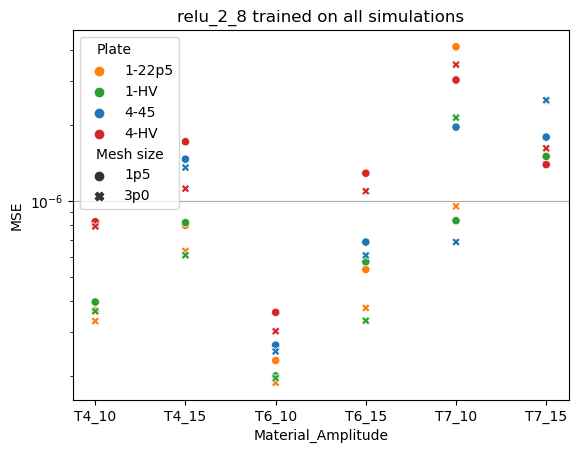

In [40]:
df = df4
ax4 = sns.scatterplot(data=df, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")
ax = ax4

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on all simulations")
plt.savefig(f"{figure_dir}/all_all.svg",bbox_inches="tight")
plt.show()

1/1 [==============================] - 0s 33ms/step


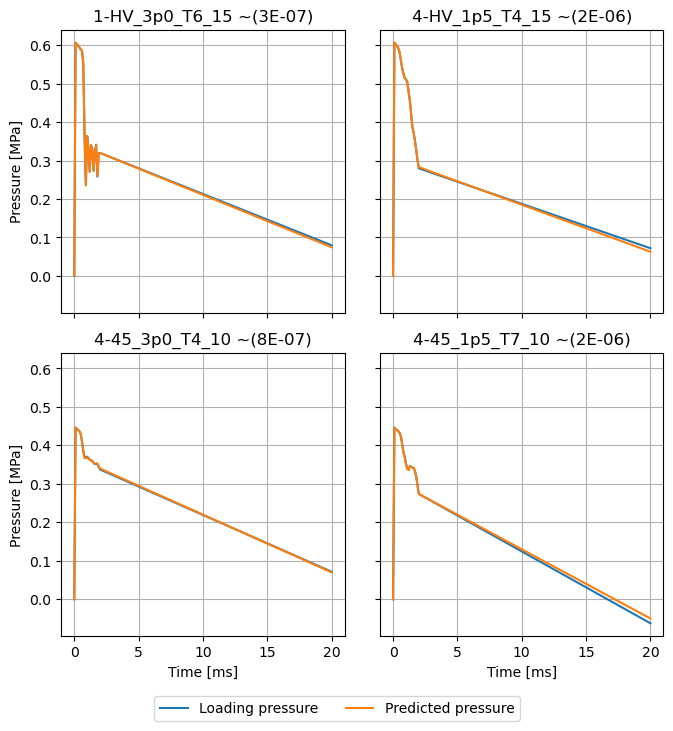

In [41]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(7,7),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1))
axs = [ax1,ax2,ax3,ax4]
names = ["1-HV_3p0_T6_15","4-HV_1p5_T4_15","4-45_3p0_T4_10","4-45_1p5_T7_10"]
df = df4
for name,ax,e in zip(names,axs,range(4)):
    db = dataset[name]
    PLAG = db["PLAG"]
    P = db["P"]
    N = db["N"]
    labels = db["labels"]
    lagp = np.ones_like(P)
    for i in range(len(lagp)):
        lagp[i] *= PLAG[i,1]

    lagp /= X_norms4[0]
    N /= X_norms4[1]
    P /= Y_norms4[0]

    nsteps = P.shape[0]
    nels = P.shape[1]
    errors = np.zeros_like(labels)
    X = np.transpose([lagp , N])
    Y = np.transpose([P])

    Y_shape = Y.shape
    prediction = model4.predict(X.reshape((Y_shape[0]*Y_shape[1],2)), batch_size=Y_shape[0]*Y_shape[1]).reshape(Y_shape)
    error = Y - prediction

    errors = np.zeros(nels)
    for i in range(nels):
        errors[i] = np.dot(error[i,:,0], error[i,:,0])/nels
    eid = errors.argmax()

    val = df[df["Job"]==name]["MSE"].max()
    ax.set_title(f"{name} ~" + f"({val:.0E})")
    ax.plot(PLAG[:,0]*1000, P[:,eid]*Y_norms4[0], label="Loading pressure")
    ax.plot(PLAG[:,0]*1000, prediction[eid,:,0]*Y_norms4[0], label="Predicted pressure")
    #plt.plot(PLAG[:,0],N[:,eid], label="N")
    #ax.legend()
    ax.grid(axis="both")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [MPa]")
    ax.label_outer()
fig.legend(labels=["Loading pressure", "Predicted pressure"], loc='center', bbox_to_anchor=(0.5, -0.02), ncol=2)

fig.tight_layout()  
fig.savefig(f"{figure_dir}/tests_all.svg",bbox_inches="tight")
plt.show()

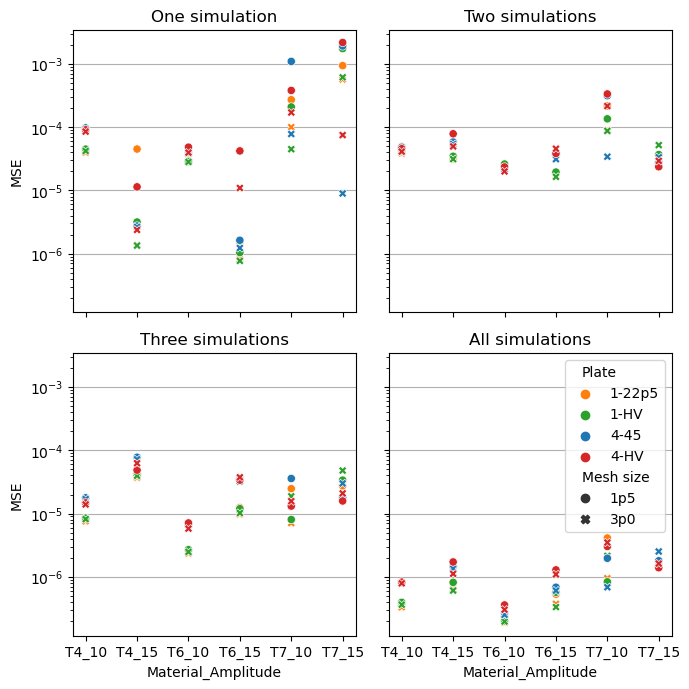

In [42]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(7,7),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1, yscale="log"))
ax1 = sns.scatterplot(ax=ax1,data=df1, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
ax2 = sns.scatterplot(ax=ax2,data=df2, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
ax3 = sns.scatterplot(ax=ax3,data=df3, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
ax4 = sns.scatterplot(ax=ax4,data=df4, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")
axs = [ax1,ax2,ax3,ax4]
titles = ["One simulation", "Two simulations", "Three simulations", "All simulations"]
for ax,title in zip(axs,titles):
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    ax.set_title(title)
fig.tight_layout()

fig.savefig(f"{figure_dir}/all_in_one.svg",bbox_inches="tight")
plt.show()

In [43]:
plags = np.zeros((48,2))
ps = np.zeros((48,2))
ns = np.zeros((48,2))
jobnames = list()

for i,(jobname,job) in enumerate(dataset.items()):
    jobnames.append(jobname)
    plags[i] = [job["PLAG"][:,1].min(), job["PLAG"][:,1].max()]
    ps[i] = [job["P"].min(), job["P"].max()]
    ns[i] = [job["N"].min(), job["N"].max()]

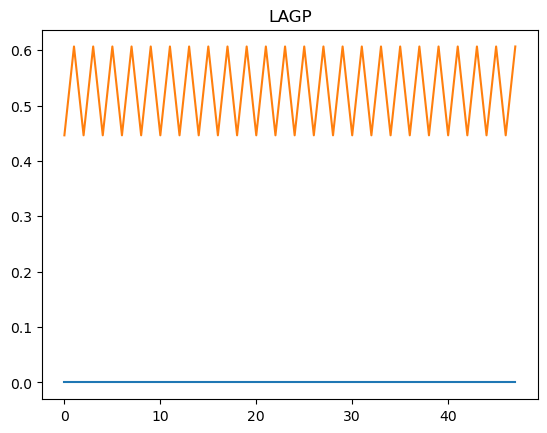

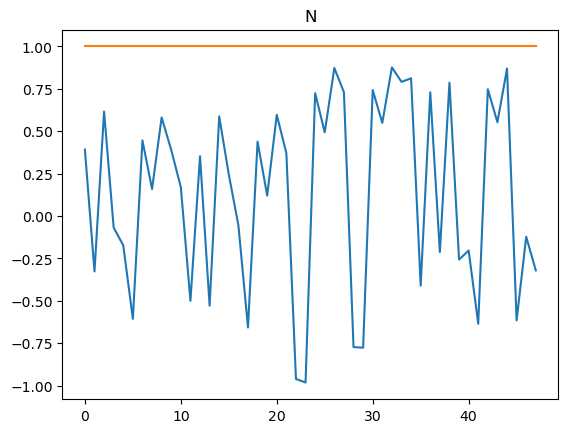

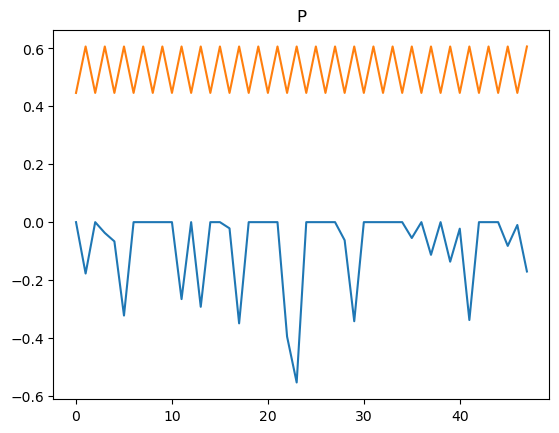

['1-HV_3p0_T7_15' '1-HV_3p0_T7_10' '4-45_1p5_T7_15' '4-45_1p5_T7_10'
 '1-HV_1p5_T7_15' '4-HV_1p5_T7_15' '4-HV_3p0_T6_15' '1-22p5_1p5_T7_15'
 '1-HV_1p5_T4_15' '1-22p5_3p0_T7_15' '4-45_3p0_T7_15' '1-22p5_1p5_T4_15'
 '4-HV_3p0_T7_15' '4-HV_1p5_T6_15' '4-HV_1p5_T4_15' '4-HV_1p5_T7_10'
 '1-22p5_1p5_T7_10' '4-HV_3p0_T7_10' '1-22p5_1p5_T6_15' '1-HV_1p5_T7_10']


In [44]:
variables = ["LAGP", "N", "P"]
values = [plags,ns, ps]

for va,val in zip(variables,values):

    plt.title(va)
    plt.plot(val[:,0], label="Min")
    plt.plot(val[:,1], label="Max")
    plt.show()

print(np.array(jobnames)[ns[:,0].argsort()[:20]])

In [45]:
df5 = evaluate_model(model5, dataset, para5["X_norms"], para5["Y_norms"])

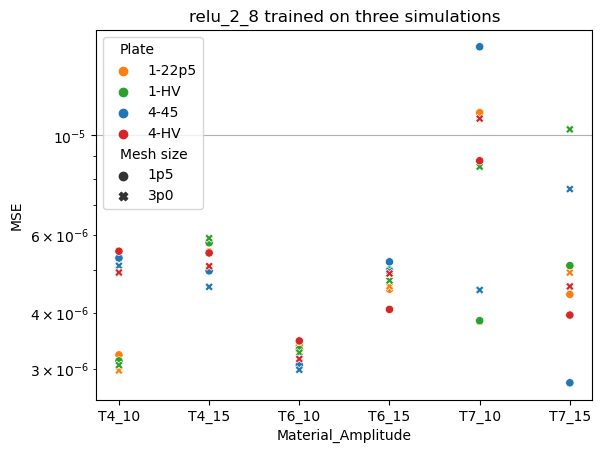

In [46]:
df = df5
ax5 = sns.scatterplot(data=df, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")
ax = ax5

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on three simulations")
plt.savefig(f"{figure_dir}/all_5.svg",bbox_inches="tight")
plt.show()

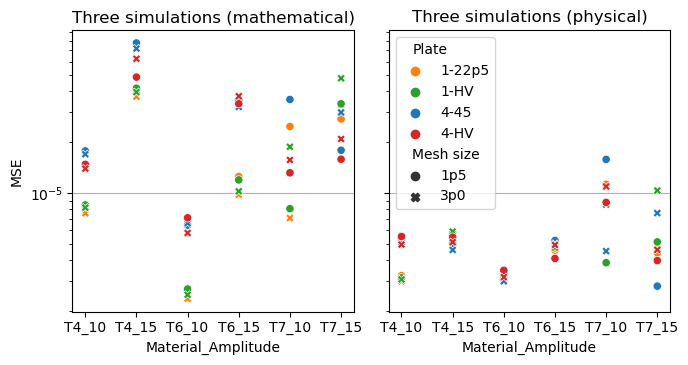

In [48]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,4),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1, yscale="log"))
ax1 = sns.scatterplot(ax=ax1,data=df3, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
ax2 = sns.scatterplot(ax=ax2,data=df5, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")

axs = [ax1,ax2]
titles = ["Three simulations (mathematical)", "Three simulations (physical)"]
for ax,title in zip(axs,titles):
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    ax.set_title(title)
fig.tight_layout()

fig.savefig(f"{figure_dir}/all_3_vs_5.svg",bbox_inches="tight")
plt.show()